In [3]:
using Plots, Random, Distributions, StatsBase, Printf, LaTeXStrings, 
    DataFrames, StatsPlots, KernelDensity, LinearAlgebra
default(fillcolor=:lightgrey, markercolor=:black, markersize=2,
    grid=false, legend=false, titlefontsize=10)

# Reversible Jump

Reversible-jump Markov chain Monte Carlo is an extension to standard Markov chain Monte Carlo (MCMC) methodology that allows simulation of the posterior distribution on spaces of varying dimensions. There are many problems in which the dimension of the parameter vector is unknown and performing inference over this dimension as well as the value of the parameter is of interest. 

Suppose we have $K$ possible models: $\mathcal{M}_1, \ldots, \mathcal{M}_K$. Each modle has a prior probability $p_k$ and is characterised by a density $f_k$ and the associated parameter space $\Theta_k$. Further, we place a prior on each paramter space, i.e.
$$\boldsymbol{\theta} | \mathcal{M}_k \sim f_k^{\text{prior}}(\boldsymbol{\theta})$$
Assume that we have observed that $y_1, \ldots y_n$. The likelihood of the model $\mathcal{M}_k$ is:
$$l_k(y_1, \ldots, y_n | \boldsymbol{\theta}) = \prod_{i=1}^nf_k(y_i | \boldsymbol{\theta})$$
We give a sinlge algorithm that can jump between different models and samples form the joint posterior:
$$f^{\text{post}}(k, \boldsymbol{\theta}) = \frac{p_kf_k^{\text{prior}}(\boldsymbol{\theta})l_k(y_1, \ldots, y_n | \boldsymbol{\theta})}{\sum_j p_j \int_{\Theta_j}f_j^{\text{prior}}(\boldsymbol{\upsilon})l_j(y_1, \ldots, y_n | \boldsymbol{\upsilon})d\boldsymbol{\upsilon}}$$

## The Algorithm

Starting with $k^{(0)}$ and $\boldsymbol{\theta}^{(0)}$ iterate for $t = 1, 2, \ldots$
1. Select model $\mathcal{M}_k$ with probability $\rho_{k^{(t-1)}\rightarrow k}$

    (With probability $\rho_{k^{(t-1)}\rightarrow k^{(t-1)}}$ update the parameters of $\mathcal{M}_{k^(t - 1)}$.)
2. Generate $\boldsymbol{u}^{(t-1)} \sim g_{k^{(t-1)} \rightarrow k}$
3. Set $(\boldsymbol{\theta}, \boldsymbol{u}) := T_{k^{(t-1)}\rightarrow k}(\boldsymbol{\theta}^{(t-1)}, \boldsymbol{u}^{(t-1)})$ 
4. Compute

$$\alpha := \min \left\{1, \frac{f^{\text{post}}(k, \boldsymbol{\theta})\rho_{k \rightarrow k^{(t-1)}}g_{k \rightarrow k^{(t-1)}}(\boldsymbol{u})}{f^{\text{post}}(k^{(t-1)}, \boldsymbol{\theta}^{(t-1)})\rho_{k^{(t-1) \rightarrow k}}g_{k^{(t-1)\rightarrow k}}(\boldsymbol{u}^{(t-1)})} \left| \frac{\partial T_{k^{(t-1)}\rightarrow k}(\boldsymbol{\theta}^{(t-1)}, \boldsymbol{u}^{(t-1)})}{\partial(\boldsymbol{\theta}^{(t-1)}, \boldsymbol{u}^{(t-1)})}\right| \right\}$$
5. With probability $\alpha$ set $k^{(t) = k}$ and $\boldsymbol{\theta}^{(t)} = \boldsymbol{\theta}$, otherwise keep $k^{(t) = k^{(t-1)}}$ and $\boldsymbol{\theta}^{(t)} = \boldsymbol{\theta}^{(t-1)}$.

<br></br>
In the above, $T_{i \rightarrow j}$ is a trasnformation that allows us to jump between the models. It must be a *diffeomorphism* (i.e. $T_{i \rightarrow j}$ has an inverse and both $T_{i \rightarrow j}$ and $T_{i \rightarrow j}^{-1}$ are differentiable) with inverse $T_{i \rightarrow j} ^ {-1} = T_{j \rightarrow i}$.

## Gaussian Mixture Model
An example application of the Reversible Jump algorithm is the Gaussian Mixture Model with an unknown number of components, i.e.

$$f(y_i | \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\tau}) = \sum_{k = 1}^{K}\pi_k\phi_k(y_i)$$

Where $K$ is unknown.

For simplicity, we assume that $\boldsymbol{\tau}$ is known and the same for all mixtures.

Priors:
$$
\begin{aligned}
\mu_k &\sim N(\mu_0, 1/\tau_0) \\
(\pi_1, \ldots, \pi_K) &\sim Dir(\alpha_1, \ldots, \alpha_K)
\end{aligned}
$$

The transdimenstional moves:
- **"birth move", $k \rightarrow k+1$.** We draw
    $$u_1 ^{(t-1)} \sim g_1, \quad u_2^{(t-1)} \sim g_2\$$
    set
    $$\pi_{k+1} = u_1 ^{(t-1)}, \quad \mu_{k+1} = u_2^{(t-1)}\$$
    and rescale
    $$\pi_{j} = \pi_{j}^{(t-1)}(1 - \pi_{k+1}), \quad j = 1, \ldots, k$$

    For this transformation, the determinant of the Jacobian of $T_{k \rightarrow k_+1}$ is 
    $$(1 - u_1^{(t-1)})^k$$

    Here $g_1$ is $\text{Beta}(1, k)$ and $g_2$ is $N(\mu_0, 1/\tau_0)$.
<br></br>
- **"death move", $k + 1 \rightarrow k$.** We drop the $k + 1$ component and rescale
    $$\pi_j = \pi_j / (1 - \pi_{k+1} ^ {(t-1)}), \quad j = 1, \ldots, k$$
    The determinant of the Jacobian of $T_{k+1 \rightarrow k}$ is 
    $$\frac{1}{(1 - \pi_{k+1}^{(t-1)})^k}$$

Finally, the probability of accepting a birth move from a model with $k$ components to a model with $k +1$ compoments is given by:

$$\alpha = \min\left\{1, \frac{p_{k+1}f_{k+1}^{\text{prior}}(\boldsymbol{\theta})l(y_1, \ldots, y_n | \boldsymbol{\theta})}{p_{k}f_{k}^{\text{prior}}(\boldsymbol{\theta}^{(t-1)})l(y_1, \ldots, y_n | \boldsymbol{\theta}^{(t-1)})}\cdot \frac{(k+1)!}{k!}\cdot\frac{\rho_{k+1 \rightarrow k}/(k + 1)}{\rho_{k \rightarrow k+1}g_1(u_1^{(t-1)})g_2(u_2^{(t-1)})}\cdot (1 - u_1^{(t-1)})^k\right\}$$
The probability of accepting the death move is $1/\alpha$.

In [47]:
function get_prob(μ; τ, Y)
    pdf.(Normal(μ, 1/τ), Y)
end

function get_posterior_ll(Y, π, μ, τ, prior_μ, prior_π)
    K = length(μ)
    ll = sum(log.(pdf.(prior_μ, μ))) + log(pdf(prior_π, π))
    ll += sum(log.(π' * transpose(reduce(hcat, get_prob.(μ, τ=τ, Y=Y))))) 
    ll
end

function draw_Z(Y; μ, π, τ)
    K = length(π)
    p = zeros(K)
    for i in range(1, K)
        p[i] = pdf(Normal(μ[i], 1/τ), Y) * π[i]
    end
    p = p ./ sum(p)
    sample([1:1:K;], Weights(p))
end

function gibbs_update(Y; μ, μ0, π, τ, τ0)
    K = length(π)
    # draw Z1, ..., Zn
    Z = draw_Z.(Y, μ=μ, π=π, τ=τ)
    # draw μ1, ..., μK
    cts = [sum(Z .== k) for k in range(1, K)]
    new_μ = zeros(K)
    μ = zeros(K)
    for k in range(1, K)
        τ_k = (cts[k] * τ + τ0)
        new_μ[k] = sum(Y[Z .== k]) * τ + τ0*μ0
        new_μ[k] = new_μ[k] / τ_k
        μ[k] = rand(Normal(new_μ[k], 1 / τ_k))
    end
    # draw π1, ..., πK
    π = rand(Dirichlet(fill(1, K) .+ cts))
    μ, π
end

function generate_jump_matrix(max_K)
    jump_matrix = zeros(max_K, max_K)
    for i in range(2, max_K - 1)
        jump_matrix[i, i - 1] = 0.1
        jump_matrix[i, i + 1] = 0.2
        jump_matrix[i, i] = 0.7
    end
    jump_matrix[1, 1] = 0.8
    jump_matrix[1, 2] = 0.2
    jump_matrix[max_K, max_K] = 0.8
    jump_matrix[max_K, max_K - 1] = 0.2
    jump_matrix
end

function birth_move(t, k, g1, g2, μ_ls, π_ls, τ, prior_μ, jump_matrix)
    u1 = rand(g1)
    u2 = rand(g2)
    while u2 < μ_ls[t - 1][k]
        u2 = rand(g2)
    end
    π = vcat(π_ls[t - 1] .* (1 - u1), u1)
    μ = vcat(μ_ls[t - 1], u2)
    log_alpha = get_posterior_ll(
        Y, π, μ, τ, prior_μ, Dirichlet(fill(1, k + 1))) - 
        get_posterior_ll(
            Y, π_ls[t - 1], μ_ls[t - 1], τ, prior_μ, Dirichlet(fill(1, k))) + 
        jump_matrix[k + 1, k] - jump_matrix[k, k + 1] - 
        log(pdf(g1, u1)) - log(pdf(g2, u2)) + 
        k * log(1 - u1)

    alpha = exp(log_alpha)
    μ, π, log_alpha
end

function death_move(t, k, g1, g2, μ_ls, π_ls, τ, prior_μ, jump_matrix)
    u2 = μ_ls[t - 1][k]
    u1 = π_ls[t - 1][k]
    π = π_ls[t - 1][1:k-1] ./ (1 - u1)
    μ = μ_ls[t - 1][1:k-1]
    log_alpha = -get_posterior_ll(
        Y, π, μ, τ, prior_μ, Dirichlet(fill(1, k - 1))) +
        get_posterior_ll(
            Y, π_ls[t - 1], μ_ls[t - 1], 
            τ, prior_μ, Dirichlet(fill(1, k))) -
        jump_matrix[k - 1, k] + jump_matrix[k, k - 1] +
        log(pdf(g1, u1)) - log(pdf(g2, u2)) -
        k * log(1 - u1)
    μ, π, log_alpha
end

function reversible_jump(Y; max_K, μ0, π0, τ0, τ, prior_μ, N_iter=20000)
    jump_matrix = generate_jump_matrix(max_K)
    K = Array{Int32, 1}(undef, N_iter)
    μ_ls = [[μ0]]
    π_ls = [[π0]]
    K[1] = 1
    for t in range(2, N_iter)
        k = K[t - 1]
        # decide to jump or to stay in the same model
        next_k = sample([1:1:max_K;], Weights(jump_matrix[k, :]))
        if next_k == k
            # update current model
            K[t] = k
            μ, π = gibbs_update(Y; μ=μ_ls[t - 1], π=π_ls[t - 1], 
                τ=τ, τ0=τ0, μ0=μ0)
            append!(μ_ls, [μ])
            append!(π_ls, [π])
        else
            g1 = Beta(1, k)
            g2 = Normal(0, 10)
            if next_k == k + 1
                # attempt to jump up
                μ, π, log_alpha =  birth_move(
                    t, k, g1, g2, μ_ls, π_ls, τ, prior_μ, jump_matrix
                )
                alpha = exp(log_alpha)
                if rand(Uniform()) > alpha
                    K[t] = k
                    append!(μ_ls, [μ_ls[t - 1]])
                    append!(π_ls, [π_ls[t - 1]])
                else
                    K[t] = k + 1
                    append!(μ_ls, [μ])
                    append!(π_ls, [π])
                end    
                
            else
                # attempt to jump down
                μ, π, log_alpha =  death_move(
                    t, k, g1, g2, μ_ls, π_ls, τ, prior_μ, jump_matrix
                )
                alpha = exp(log_alpha)
                if rand(Uniform()) > alpha
                    K[t] = k
                    append!(μ_ls, [μ_ls[t - 1]])
                    append!(π_ls, [π_ls[t - 1]])
                else
                    K[t] = k - 1
                    append!(μ_ls, [μ])
                    append!(π_ls, [π])
                end
            end       
        end
    end
    μ_ls, π_ls, K
end

function plot_estimates(param, k)
    y = transpose(reduce(hcat, param[K .== k]))
    p = plot(y, layout = (1, 2), subplot = 1, size = (800, 400))
    plot!(p, cumsum(y, dims = 1) ./ [1:1:size(y)[1];], subplot = 2)
    display(p)
end;

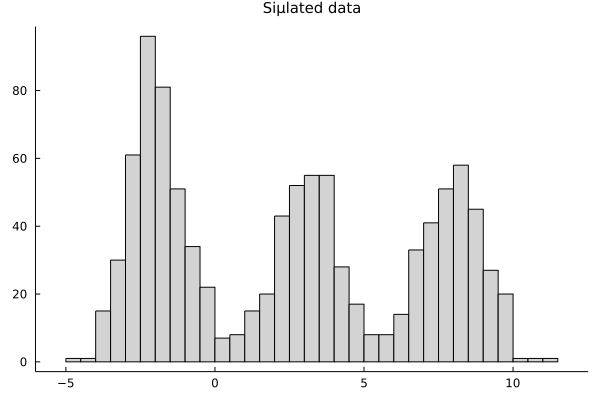

In [48]:
# parameters
μ = [-2, 3, 8]
τ = 1
π = [0.4, 0.3, 0.3]
N = 1000
K = length(μ)

# data siμlation
Y = zeros(0)
for i in range(1, K)
    append!(Y, rand(Normal(μ[i], 1/τ), Int(N * π[i])))
end

histogram(Y, bins=40, title="Siμlated data")

In [49]:
μ_ls, π_ls, K = reversible_jump(
    Y, 
    max_K=4,
    μ0=0.0, 
    π0=1.0, 
    τ0=1.0, 
    τ=1.0, 
    prior_μ=Normal(0,10)
);

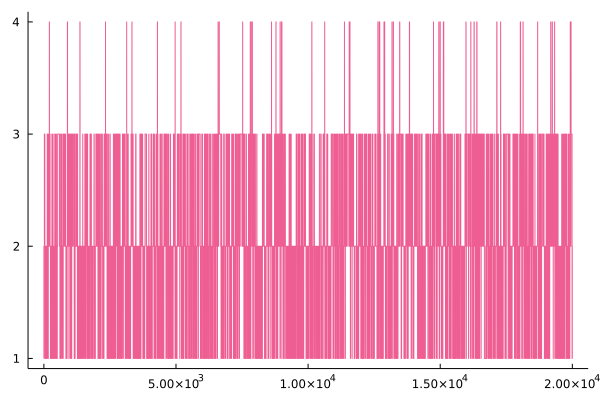

In [50]:
plot(K, color=7)

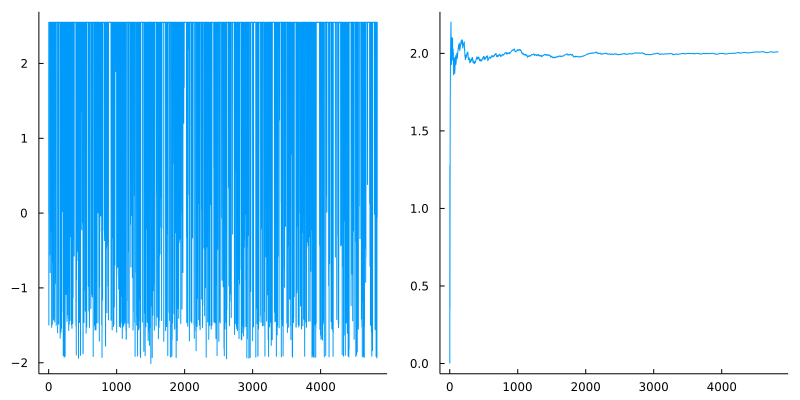

In [51]:
plot_estimates(μ_ls, 1)

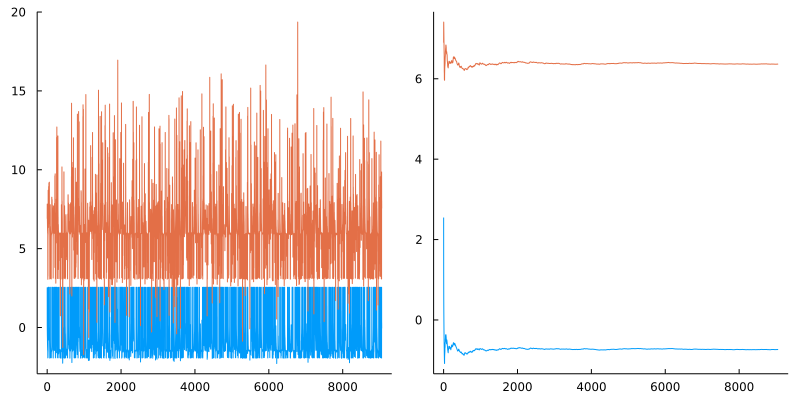

In [52]:
plot_estimates(μ_ls, 2)

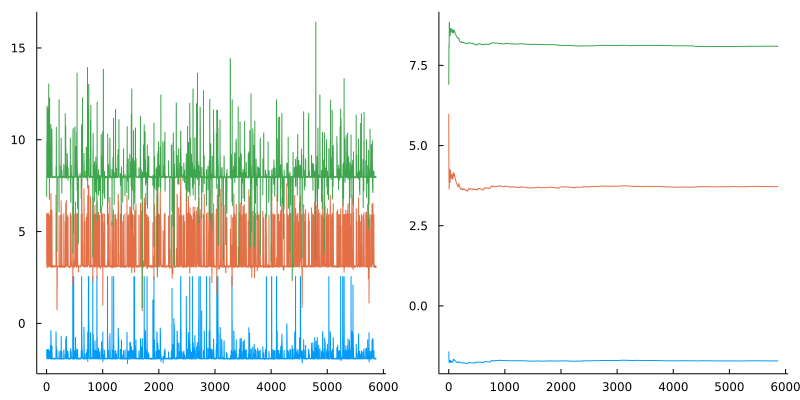

In [53]:
plot_estimates(μ_ls, 3)

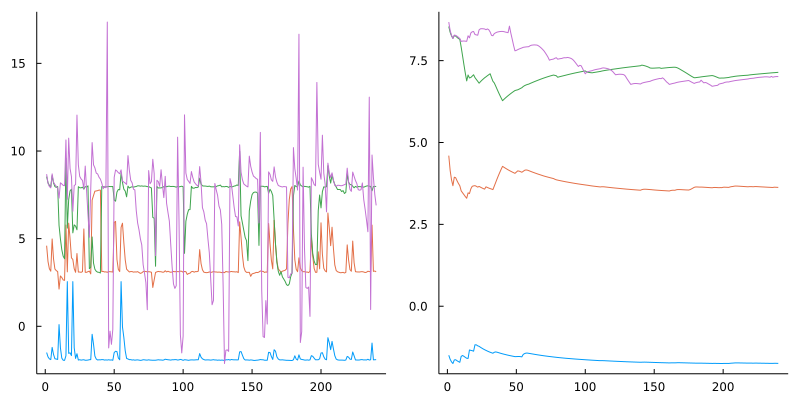

In [54]:
plot_estimates(μ_ls, 4)

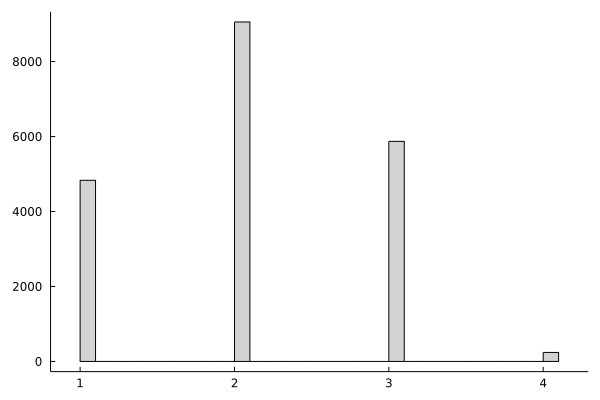

In [55]:
histogram(K)

---
Bibliography:
1. ST407 Monte Carlo Methods - Lecture notes by Adam M. Johansen (University of Warwick)